# Model Training: Boosting Models (XGBoost & LightGBM)

Ce notebook charge les données prétraitées et entraîne des modèles de gradient boosting pour la prévision de la demande.

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import joblib
import os
import matplotlib.pyplot as plt

# Création du dossier pour les modèles si nécessaire
os.makedirs('trained_models', exist_ok=True)

print("✅ Bibliothèques importées et dossier vérifié.")

✅ Bibliothèques importées et dossier vérifié.


/home/raph/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


## Chargement des Données
Nous utilisons les datasets générés par le notebook de prétraitement.

In [2]:
train_path = 'train_boosting.csv'
test_path = 'test_boosting.csv'

if not os.path.exists(train_path) or not os.path.exists(test_path):
    raise FileNotFoundError("Les fichiers train_boosting.csv ou test_boosting.csv sont introuvables. Veuillez exécuter le notebook pretraitement.ipynb d'abord.")

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

print(f"📦 Train shape: {train_df.shape}")
print(f"📦 Test shape: {test_df.shape}")

📦 Train shape: (24300, 71)
📦 Test shape: (42800, 71)


## Préparation des Features et Target
Nous allons utiliser `target_7` pour prédire la demande à 7 jours. Nous excluons `target_30` des features. Nous filtrons aussi les colonnes non-numériques.

In [3]:
# Définition des cibles et features à exclure
target_col = 'target_7'
drop_cols = ['target_7', 'target_30']

# Séparation X et y
X_train = train_df.drop(columns=drop_cols, errors='ignore')
y_train = train_df[target_col]

X_test = test_df.drop(columns=drop_cols, errors='ignore')
y_test = test_df[target_col]

# Suppression des colonnes non numériques (Date, ID, etc.)
X_train = X_train.select_dtypes(include=[np.number])
X_test = X_test.select_dtypes(include=[np.number])

# Alignement des colonnes (au cas où)
X_train = X_train[X_test.columns]

print(f"Features utilisées: {len(X_train.columns)}")
print(f"Colonnes conservées: {list(X_train.columns)}")

Features utilisées: 34
Colonnes conservées: ['Inventory Level', 'Units Sold', 'Units Ordered', 'Demand Forecast', 'Price', 'Discount', 'Holiday/Promotion', 'Competitor Pricing', 'week', 'month', 'quarter', 'day_of_week', 'is_weekend', 'is_month_start', 'is_month_end', 'lag_1', 'lag_7', 'lag_14', 'lag_30', 'roll_mean_7', 'roll_std_7', 'roll_mean_14', 'roll_std_14', 'roll_mean_30', 'roll_std_30', 'price_after_discount', 'price_vs_competitor', 'promo_active', 'stock_ratio', 'order_to_sales', 'bad_weather', 'is_holiday', 'promo_weekend', 'holiday_discount']


## Entraînement XGBoost

In [4]:
print("⏳ Entraînement XGBoost en cours...")
xgb_model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    early_stopping_rounds=50,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=100
)

print("✅ XGBoost entraîné.")

# Sauvegarde
xgb_path = 'trained_models/xgboost_model.pkl'
joblib.dump(xgb_model, xgb_path)
print(f"💾 Modèle sauvegardé sous : {xgb_path}")

⏳ Entraînement XGBoost en cours...
[0]	validation_0-rmse:109.30799	validation_1-rmse:109.09884
[49]	validation_0-rmse:105.92567	validation_1-rmse:109.28195
✅ XGBoost entraîné.
💾 Modèle sauvegardé sous : trained_models/xgboost_model.pkl


## Entraînement LightGBM

In [5]:
print("⏳ Entraînement LightGBM en cours...")
lgb_model = lgb.LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='rmse',
    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(100)]
)

print("✅ LightGBM entraîné.")

# Sauvegarde
lgb_path = 'trained_models/lightgbm_model.pkl'
joblib.dump(lgb_model, lgb_path)
print(f"💾 Modèle sauvegardé sous : {lgb_path}")

⏳ Entraînement LightGBM en cours...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.067842 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5105
[LightGBM] [Info] Number of data points in the train set: 24300, number of used features: 34
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 137.137449
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	valid_0's rmse: 109.092	valid_0's l2: 11901.2
✅ LightGBM entraîné.
💾 Modèle sauvegardé sous : trained_models/lightgbm_model.pkl


## Évaluation des Modèles


📊 Évaluation sur le Test Set :
--- XGBoost ---
RMSE: 109.0988
MAE:  89.3164
--- LightGBM ---
RMSE: 109.0925
MAE:  89.3084


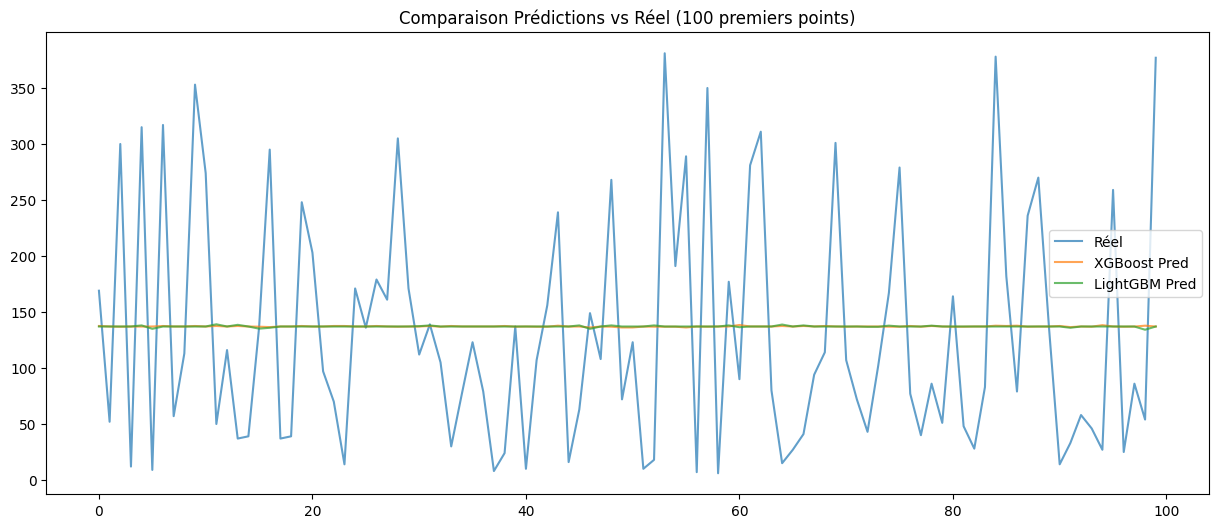

In [6]:
def evaluate_model(model, name, X, y):
    preds = model.predict(X)
    rmse = np.sqrt(mean_squared_error(y, preds))
    mae = mean_absolute_error(y, preds)
    print(f"--- {name} ---")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE:  {mae:.4f}")
    return preds

print("\n📊 Évaluation sur le Test Set :")
xgb_preds = evaluate_model(xgb_model, "XGBoost", X_test, y_test)
lgb_preds = evaluate_model(lgb_model, "LightGBM", X_test, y_test)

# Visualisation rapide
plt.figure(figsize=(15, 6))
plt.plot(y_test.values[:100], label='Réel', alpha=0.7)
plt.plot(xgb_preds[:100], label='XGBoost Pred', alpha=0.7)
plt.plot(lgb_preds[:100], label='LightGBM Pred', alpha=0.7)
plt.title("Comparaison Prédictions vs Réel (100 premiers points)")
plt.legend()
plt.show()